In [12]:
import osmnx as ox
import geopandas as gpd
import json
from shapely.geometry import MultiPolygon, Polygon

ox.settings.default_crs = "epsg:25832"

gdf = gpd.GeoDataFrame()
mongo_data_list = []

def create_postal_code_gdf(place_name, tags):
    global gdf, mongo_data_list

    place_polygons = ox.features_from_place(place_name, tags)
    polygon_mask = place_polygons['geometry'].apply(lambda geom: isinstance(geom, (Polygon, MultiPolygon)))

    gdf = gpd.GeoDataFrame(place_polygons[polygon_mask].dropna(subset=['postal_code', 'geometry']))

    for idx, row in gdf.iterrows():
        postal_code = row['postal_code']
        geometry = row['geometry']

        geojson_geometry = json.loads(gpd.GeoSeries(geometry).to_json())['features'][0]['geometry']

        postal_code_data = {
            "postal_code": postal_code,
            "geometry": geojson_geometry
        }

        mongo_data_list.append(postal_code_data)

# Example usage
place_name = "Germany"
tags = {"boundary": "postal_code"}
create_postal_code_gdf(place_name, tags)

with open('Germany_postal_codes.geojson', 'w') as file:
    json.dump({"type": "FeatureCollection", "features": mongo_data_list}, file, indent=2)


8274

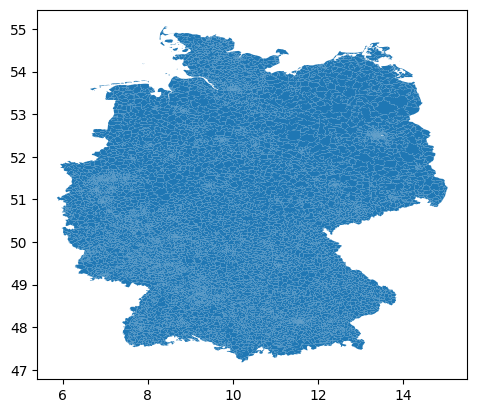

In [13]:
gdf.plot()
len(mongo_data_list)


In [14]:
from pymongo import MongoClient
import json

class MongoDBConnector:
    def __init__(self, database_name, collection_name):
        self.client = MongoClient('localhost', 27017)
        self.db = self.client[database_name]
        self.collection = self.db[collection_name]

    def connect_to_local_mongodb(self):
        print("Connected to local MongoDB")
        return self.client, self.collection

    def insert_geojson_data(self, geojson_file_path, chunk_size=1000):
        with open(geojson_file_path, 'r') as file:
            geojson_data = json.load(file)

        features = geojson_data['features']
        for i in range(0, len(features), chunk_size):
            chunk = features[i:i + chunk_size]
            self.collection.insert_many(chunk)
            print(f"Inserted {len(chunk)} features into local MongoDB collection '{self.collection.name}'.")

    def close_connection(self):
        self.client.close()
        print("Closed MongoDB connection.")

# Example usage
if __name__ == "__main__":
    database_name = "ZIP_Poly_Ger_DB_e"
    collection_name = "ZIP_Poly_Ger_Collection_e"

    mongo_connector = MongoDBConnector(database_name, collection_name)
    mongo_client, mongo_collection = mongo_connector.connect_to_local_mongodb()

    geojson_file_path = 'Germany_postal_codes.geojson'
    mongo_connector.insert_geojson_data(geojson_file_path, chunk_size=1000)

    mongo_connector.close_connection()


Connected to local MongoDB
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 274 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Closed MongoDB connection.


In [15]:
from shapely.geometry import shape, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from pymongo import MongoClient

ox.settings.default_crs = "epsg:25832"

def connect_to_mongodb(database_name, collection_name):
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection

def retrieve_data_from_mongodb(collection):
    cursor = collection.find()
    geojson_data = {"type": "FeatureCollection", "features": []}

    for document in cursor:
        geojson_data["features"].append(document)

    return geojson_data

def coordinates_to_polygon(coordinates):
    return Polygon(coordinates)

def plot_polygon(postal_code_polygons, postal_code):
    polygon = postal_code_polygons.get(postal_code)
    if polygon:
        gdf = gpd.GeoDataFrame(geometry=[polygon])
        gdf.plot()
        plt.title(f"Postal Code Polygon: {postal_code}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
        return polygon
    else:
        print(f"No polygon found for postal code: {postal_code}")
        return None

# Example usage
if __name__ == "__main__":
    database_name = "ZIP_Poly_Ger_DB_e"
    collection_name = "ZIP_Poly_Ger_Collection_e"

    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    geojson_data_from_mongo = retrieve_data_from_mongodb(mongo_collection)

    postal_code_polygons_mongo = {document.get('postal_code'): coordinates_to_polygon(
        document.get('geometry')['coordinates'][0]) for document in geojson_data_from_mongo['features']}

    input_postal_code = input("Enter a postal code: ")

    selected_polygon = plot_polygon(postal_code_polygons_mongo, input_postal_code)

    if selected_polygon:
        print("Selected Polygon Information:")
        print(selected_polygon)

    mongo_client.close()


TypeError: float() argument must be a string or a real number, not 'list'

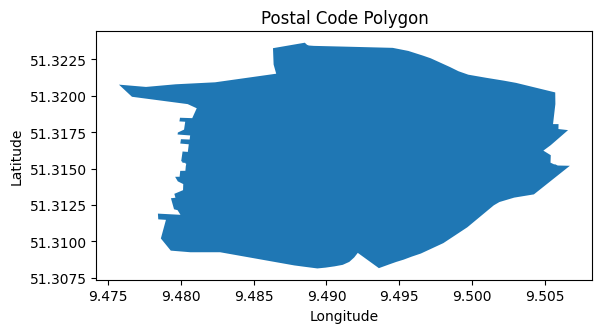

The postal code for the point (51.316669, 9.5) is: 34117
Selected Polygon Information:
POLYGON ((9.4757436 51.3207645, 9.4776032 51.3206073, 9.4796463 51.3207892, 9.4823482 51.320925, 9.4865459 51.3215156, 9.4863685 51.3221459, 9.4863246 51.3232692, 9.4885094 51.323645, 9.4886636 51.3235004, 9.4887893 51.3234516, 9.4891333 51.3234269, 9.491381 51.3233725, 9.4945481 51.3232914, 9.4956217 51.3230797, 9.4966232 51.3227593, 9.4971661 51.3225718, 9.4984949 51.321968, 9.499068 51.3216853, 9.4997424 51.3214482, 9.5009621 51.3212365, 9.5021754 51.3210394, 9.5030204 51.3208864, 9.5057135 51.3202296, 9.5057238 51.3194333, 9.5055623 51.3180545, 9.5059413 51.3180525, 9.5059333 51.3177153, 9.506594 51.3176393, 9.5054007 51.3166035, 9.5048986 51.3162318, 9.5054078 51.3159155, 9.5053889 51.3154057, 9.5056556 51.3152783, 9.505686 51.3153018, 9.5058858 51.3152088, 9.5067184 51.3151902, 9.5042477 51.3132263, 9.5028925 51.3130033, 9.5018798 51.312701, 9.5014944 51.3124757, 9.4996728 51.3109643, 9.4980295

In [16]:
from shapely.geometry import MultiPolygon, Polygon, Point
import matplotlib.pyplot as plt
from pymongo import MongoClient

ox.settings.default_crs = "epsg:25832"

def connect_to_mongodb(database_name, collection_name):
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection

def retrieve_data_from_mongodb(collection):
    cursor = collection.find()
    geojson_data = {"type": "FeatureCollection", "features": []}

    for document in cursor:
        geojson_data["features"].append(document)

    return geojson_data

def coordinates_to_geometry(coordinates):
    if isinstance(coordinates[0][0], list):
        return MultiPolygon([Polygon(part) for part in coordinates])
    else:
        return Polygon(coordinates)

def insert_data_to_mongodb(data, collection):
    collection.insert_many(data['features'])
    print(f"Inserted {len(data['features'])} features into MongoDB collection '{collection.name}'.")

def plot_polygon(polygon):
    gdf = gpd.GeoDataFrame(geometry=[polygon])
    gdf.plot()
    plt.title("Postal Code Polygon")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

def get_postal_code_for_point(point, postal_code_polygons):
    for postal_code, polygon in postal_code_polygons.items():
        if polygon.contains(point):
            return postal_code, polygon

    return None, None

# Example usage
if __name__ == "__main__":
    database_name = "ZIP_Poly_Ger_DB_e"
    collection_name = "ZIP_Poly_Ger_Collection_e"

    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    geojson_data_from_mongo = retrieve_data_from_mongodb(mongo_collection)

    postal_code_polygons_mongo = {document.get('postal_code'): coordinates_to_geometry(
        document.get('geometry')['coordinates'][0]) for document in geojson_data_from_mongo['features']}

    latitude = float(51.316669)
    longitude = float(9.500000)
    point = Point(longitude, latitude)

    postal_code, selected_polygon = get_postal_code_for_point(point, postal_code_polygons_mongo)

    if postal_code and selected_polygon:
        plot_polygon(selected_polygon)
        print(f"The postal code for the point ({latitude}, {longitude}) is: {postal_code}")
        print("Selected Polygon Information:")
        print(selected_polygon)
    else:
        print(f"No postal code found for the point ({latitude}, {longitude}).")

    mongo_client.close()


Still Testing

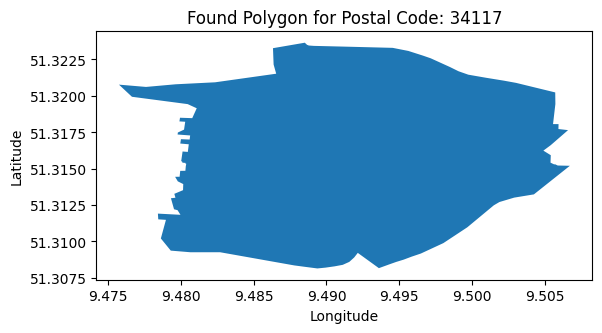

The postal code for the given polygon is: 34117


In [17]:
from shapely.geometry import Polygon, MultiPolygon
from pymongo import MongoClient
import geopandas as gpd
import matplotlib.pyplot as plt

def connect_to_mongodb(database_name, collection_name):
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection

def retrieve_data_from_mongodb(collection):
    cursor = collection.find()
    geojson_data = {"type": "FeatureCollection", "features": []}

    for document in cursor:
        geojson_data["features"].append(document)

    return geojson_data

def coordinates_to_geometry(geometry_type, coordinates):
    if geometry_type == 'Polygon':
        return Polygon(coordinates[0])
    elif geometry_type == 'MultiPolygon':
        return MultiPolygon([Polygon(shell) for shell in coordinates])
    else:
        return None

def find_postal_code_for_polygon(target_polygon, postal_code_polygons):
    for postal_code, polygon in postal_code_polygons.items():
        if polygon.intersects(target_polygon):
            return postal_code
    return None

if __name__ == "__main__":
    database_name = "ZIP_Poly_Ger_DB_c"
    collection_name = "ZIP_Poly_Ger_Collection_c"

    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    geojson_data_from_mongo = retrieve_data_from_mongodb(mongo_collection)

    postal_code_polygons_mongo = {}
    for document in geojson_data_from_mongo['features']:
        postal_code = document.get('postal_code')
        geometry_type = document.get('geometry', {}).get('type')
        coordinates = document.get('geometry', {}).get('coordinates')

        if postal_code and geometry_type and coordinates:
            geometry = coordinates_to_geometry(geometry_type, coordinates)
            if geometry:
                postal_code_polygons_mongo[postal_code] = geometry

    example_polygon = Polygon([
        (9.4757436, 51.3207645),
        (9.4776032, 51.3206073),
        # ... (add the remaining coordinates)
        (9.4757436, 51.3207645)
    ])

    found_postal_code = find_postal_code_for_polygon(example_polygon, postal_code_polygons_mongo)

    if found_postal_code:
        found_polygon = postal_code_polygons_mongo[found_postal_code]
        gdf_found = gpd.GeoDataFrame(geometry=[found_polygon])
        gdf_found.plot()
        plt.title(f"Found Polygon for Postal Code: {found_postal_code}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
    else:
        print("No postal code found for the given polygon.")

    found_geojson = gdf_found.to_json() if found_postal_code else None

    if found_postal_code:
        print(f"The postal code for the given polygon is: {found_postal_code}")

    mongo_client.close()
